In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import utils
import feature_extraction

In [2]:
DATA_DIR = 'Data'
CACHE_DIR = 'Cache'
SPEAKER_INFO_FILE_PATH = os.path.join(DATA_DIR, 'speaker_attributes.parquet')

In [3]:
@utils.cache_to_file_pickle("function-dataset_stats", cache_dir = CACHE_DIR)
def dataset_stats(data_dir, speaker_info_file_path):
    qid_labels, linkcounts = utils.query_wikidata_for_linkcounts_and_labels(data_dir = DATA_DIR, speaker_info_file_path = SPEAKER_INFO_FILE_PATH)
    speaker_data = pd.read_parquet(speaker_info_file_path, columns = ['id', 'date_of_birth', 'gender', 'occupation', 'nationality', 'ethnic_group', 'religion']).set_index('id').to_dict('index') 

    num_occurrences_counts = {}
    speaker_info_counts = {}
    for key in ['Age', 'Gender', 'Occupation', 'Nationality', 'Ethnicity', 'Religion']:
        speaker_info_counts[key] = {'Available': 0, 'Not Available': 0, 'Not Weighted': {}, 'Weighted by Quote Counts': {}, 'Weighted by Number of Occurrences': {}}
        
    for line in utils.json_lines_generator(data_dir):
        line_num_occurrences = line['numOccurrences']
        num_occurrences_counts[line_num_occurrences] = num_occurrences_counts.get(line_num_occurrences, 0) + 1
        
        # Solve ambiguities in speaker qids due to homonyms.
        speaker = feature_extraction.solve_ambiguous_speakers(line['qids'], linkcounts)
        
        # Calculate speaker age.
        speaker_birth_date = speaker_data.get(speaker, {}).get('date_of_birth', None)
        speaker_age = feature_extraction.get_speaker_age(speaker_birth_date, line['date'])
        if speaker_age is None:
            speaker_info_counts['Age']['Not Available'] += 1
        else:    
            speaker_info_counts['Age']['Available'] += 1
            speaker_info_counts['Age']['Not Weighted'][speaker_age] = 1
            previous = speaker_info_counts['Age']['Weighted by Quote Counts'].get(speaker_age, 0)
            speaker_info_counts['Age']['Weighted by Quote Counts'][speaker_age] = previous + 1
            previous = speaker_info_counts['Age']['Weighted by Number of Occurrences'].get(speaker_age, 0)
            speaker_info_counts['Age']['Weighted by Number of Occurrences'][speaker_age] = previous + line_num_occurrences

        # For all other keys, the procedure is the same.
        for key_speaker_data, key_speaker_info_counts in [('gender', 'Gender'), 
                                                          ('occupation', 'Occupation'), 
                                                          ('nationality', 'Nationality'), 
                                                          ('ethnic_group', 'Ethnicity'),
                                                          ('religion', 'Religion')]:
            # Extract value.
            speaker_value = speaker_data.get(speaker, {}).get(key_speaker_data, None)
            if speaker_value is None or len(speaker_value) == 0:
                speaker_info_counts[key_speaker_info_counts]['Not Available'] += 1
            else:
                speaker_info_counts[key_speaker_info_counts]['Available'] += 1

                # For people with multiple value for one statistic, we simply add the weight of the quote to each possibility.
                for possibility in speaker_value:
                    possibility = qid_labels.get(possibility, None)
                    if possibility is None:
                        continue

                    speaker_info_counts[key_speaker_info_counts]['Not Weighted'][possibility] = 1
                    previous = speaker_info_counts[key_speaker_info_counts]['Weighted by Quote Counts'].get(possibility, 0)
                    speaker_info_counts[key_speaker_info_counts]['Weighted by Quote Counts'][possibility] = previous + 1
                    previous = speaker_info_counts[key_speaker_info_counts]['Weighted by Number of Occurrences'].get(possibility, 0)
                    speaker_info_counts[key_speaker_info_counts]['Weighted by Number of Occurrences'][possibility] = previous + line_num_occurrences

    return num_occurrences_counts, speaker_info_counts
        
num_occurrences_counts, speaker_info_counts = dataset_stats(data_dir = DATA_DIR, speaker_info_file_path = SPEAKER_INFO_FILE_PATH)

Starting processing Data\quotes-2015.json.bz2
Processed 1000000 lines from Data\quotes-2015.json.bz2 in 0.644 minutes
Processed 2000000 lines from Data\quotes-2015.json.bz2 in 1.270 minutes
Processed 3000000 lines from Data\quotes-2015.json.bz2 in 1.890 minutes
Processed 4000000 lines from Data\quotes-2015.json.bz2 in 2.542 minutes
Processed 5000000 lines from Data\quotes-2015.json.bz2 in 3.188 minutes
Processed 6000000 lines from Data\quotes-2015.json.bz2 in 3.829 minutes
Processed 7000000 lines from Data\quotes-2015.json.bz2 in 4.439 minutes
Processed 8000000 lines from Data\quotes-2015.json.bz2 in 5.058 minutes
Processed 9000000 lines from Data\quotes-2015.json.bz2 in 5.698 minutes
Processed 10000000 lines from Data\quotes-2015.json.bz2 in 6.325 minutes
Processed 11000000 lines from Data\quotes-2015.json.bz2 in 6.941 minutes
Processed 12000000 lines from Data\quotes-2015.json.bz2 in 7.564 minutes
Processed 13000000 lines from Data\quotes-2015.json.bz2 in 8.243 minutes
Processed 1400

Processed 21000000 lines from Data\quotes-2019.json.bz2 in 13.608 minutes
Finished processing Data\quotes-2019.json.bz2 in 14.119 minutes
Starting processing Data\quotes-2020.json.bz2
Processed 1000000 lines from Data\quotes-2020.json.bz2 in 0.648 minutes
Processed 2000000 lines from Data\quotes-2020.json.bz2 in 1.272 minutes
Processed 3000000 lines from Data\quotes-2020.json.bz2 in 1.896 minutes
Processed 4000000 lines from Data\quotes-2020.json.bz2 in 2.525 minutes
Processed 5000000 lines from Data\quotes-2020.json.bz2 in 3.147 minutes
Finished processing Data\quotes-2020.json.bz2 in 3.299 minutes


### What is a Viral Quote?

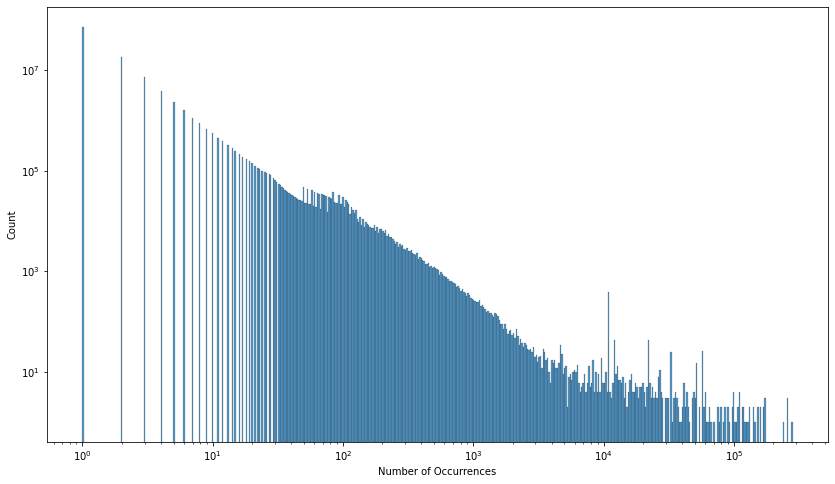

In [20]:
plt.figure(figsize = (14, 8))
df_num_occurrences_counts = pd.DataFrame(num_occurrences_counts.items(), columns = ['Number of Occurrences', 'Count'])
sns.histplot(df_num_occurrences_counts, x = 'Number of Occurrences', weights = 'Count', bins = 500, log_scale = (True, True));

#### IT'S A POWER LAW (MAYBE)!

In [73]:
from statsmodels.stats.weightstats import DescrStatsW

def describe_weighted_stats(values, weights, percentiles = []):
    values, weights = list(values), list(weights)
    
    stats = DescrStatsW(values, weights = weights, ddof = 0)
    stats_dict = {'count': stats.sum_weights, 'mean': stats.mean, 'std': stats.std, 'min': stats.quantile(0.).item()}
    
    for percentile in sorted([0.25, 0.5, 0.75] + percentiles):
        stats_dict[f'{100*percentile}%'] = stats.quantile(percentile).item()
    
    stats_dict['max'] = stats.quantile(1.).item()
    
    return stats_dict

In [74]:
describe_weighted_stats(num_occurrences_counts.keys(), 
                        num_occurrences_counts.values(),
                        percentiles = [0.95, 0.96, 0.97, 0.98, 0.99, 0.995, 0.999])

{'count': 115584257.0,
 'mean': 3.9926449672121005,
 'std': 113.83433159703254,
 'min': 1,
 '25.0%': 1,
 '50.0%': 1,
 '75.0%': 2,
 '95.0%': 10,
 '96.0%': 13,
 '97.0%': 17,
 '98.0%': 26,
 '99.0%': 55,
 '99.5%': 90,
 '99.9%': 215,
 'max': 282552}

In [78]:
viral_thr = 100

num_cited_more_thr = sum(value for key, value in num_occurrences_counts.items() if key >= viral_thr)
num_cited_less_thr = sum(value for key, value in num_occurrences_counts.items() if key < viral_thr)

print(f"{num_cited_less_thr/(num_cited_less_thr + num_cited_more_thr):.3%} of quotes are quoted less than {viral_thr} times")
print(f"Quotes cited {viral_thr} times or more:", num_cited_more_thr)
print(f"Quotes cited less than {viral_thr} times:", num_cited_less_thr)

99.587% of quotes are quoted less than 100 times
Quotes cited 100 times or more: 477879
Quotes cited less than 100 times: 115106378


### Plots Speaker Information

**Double Check they look like Celina's ones. There may be a hidden bug in dataset_stats function, or whatever. Worth triple checking.**